In [24]:
import os
import re
import sys
import glob
import copy
import time
import random
import datetime
import argparse
import subprocess
import numpy as np
import pandas as pd
import itertools as it
import multiprocessing

import numpy as np
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [25]:
gff3cols = ["seqid","source","type","start","end","score","strand","phase","attributes"]

base_dir = "analysis_21042020/"
num_tissues = 3
num_samples = 10

In [26]:
results = list()
types = ["real","splicing","intronic","intergenic"]

def count_repeats(fname):
    total_lower = 0
    total_upper = 0
    with open(fname,"r") as inFP:
        for line in inFP.readlines():
            if line[0]==">":
                continue
            else:
                total_lower += sum(map(str.islower,line.rstrip("\n")))
                total_upper += sum(map(str.isupper,line.rstrip("\n")))
    return total_upper,total_lower

for tp in types:
    for nt in range(num_tissues):
        for ns in range(num_samples):
            fname = base_dir+tp+".t"+str(nt)+"_s"+str(ns)+".fasta"
            n_upper,n_lower = count_repeats(fname)
            results.append([n_upper,"non_repeat",tp,nt,ns])
            results.append([n_lower,"repeat",tp,nt,ns])

In [27]:
# transform into dataframe
df = pd.DataFrame.from_dict(results)
df.columns = ["num_bases","repeat","type","tissue","sample"]
df

,num_bases,repeat,type,tissue,sample
0,85538779,non_repeat,real,0,0
1,18885557,repeat,real,0,0
2,63332993,non_repeat,real,0,1
3,14825902,repeat,real,0,1
4,63160388,non_repeat,real,0,2
...,...,...,...,...,...
235,28161,repeat,intergenic,2,7
236,17569,non_repeat,intergenic,2,8
237,23301,repeat,intergenic,2,8
238,18797,non_repeat,intergenic,2,9


In [28]:
# aggregate for numbers
tmp = df.pivot_table(index="repeat",columns="type",values="num_bases",aggfunc=sum).T.reset_index()
tmp["total"] = tmp["repeat"]+tmp["non_repeat"]
tmp["perc_repeat"] = (tmp["repeat"]/tmp["total"])*100
tmp

repeat,type,non_repeat,repeat,total,perc_repeat
0,intergenic,668478,863214,1531692,56.356892
1,intronic,8694095,9846814,18540909,53.108583
2,real,2202812279,491947894,2694760173,18.255721
3,splicing,919930906,258833331,1178764237,21.958024


In [29]:
# get percent repeats by sample
def get_perc(grp):
    assert len(grp)==2,"wrong group"
    repeat = grp[grp["repeat"]=="repeat"]["num_bases"].iloc[0]
    no_repeat = grp[grp["repeat"]=="non_repeat"]["num_bases"].iloc[0]
    return (float(repeat)/float(repeat+no_repeat))*100
tmp2 = pd.DataFrame(df.groupby(by=["type","tissue","sample"]).apply(lambda grp: get_perc(grp))).reset_index()
tmp2.columns = ["type","tissue","sample","perc_repeat"]
tmp2

,type,tissue,sample,perc_repeat
0,intergenic,0,0,56.491381
1,intergenic,0,1,55.770181
2,intergenic,0,2,55.547259
3,intergenic,0,3,55.653877
4,intergenic,0,4,58.104008
...,...,...,...,...
115,splicing,2,5,22.623046
116,splicing,2,6,21.946446
117,splicing,2,7,21.964411
118,splicing,2,8,22.293458


Text(0, 0.5, '% Repeat-Masked Bases')

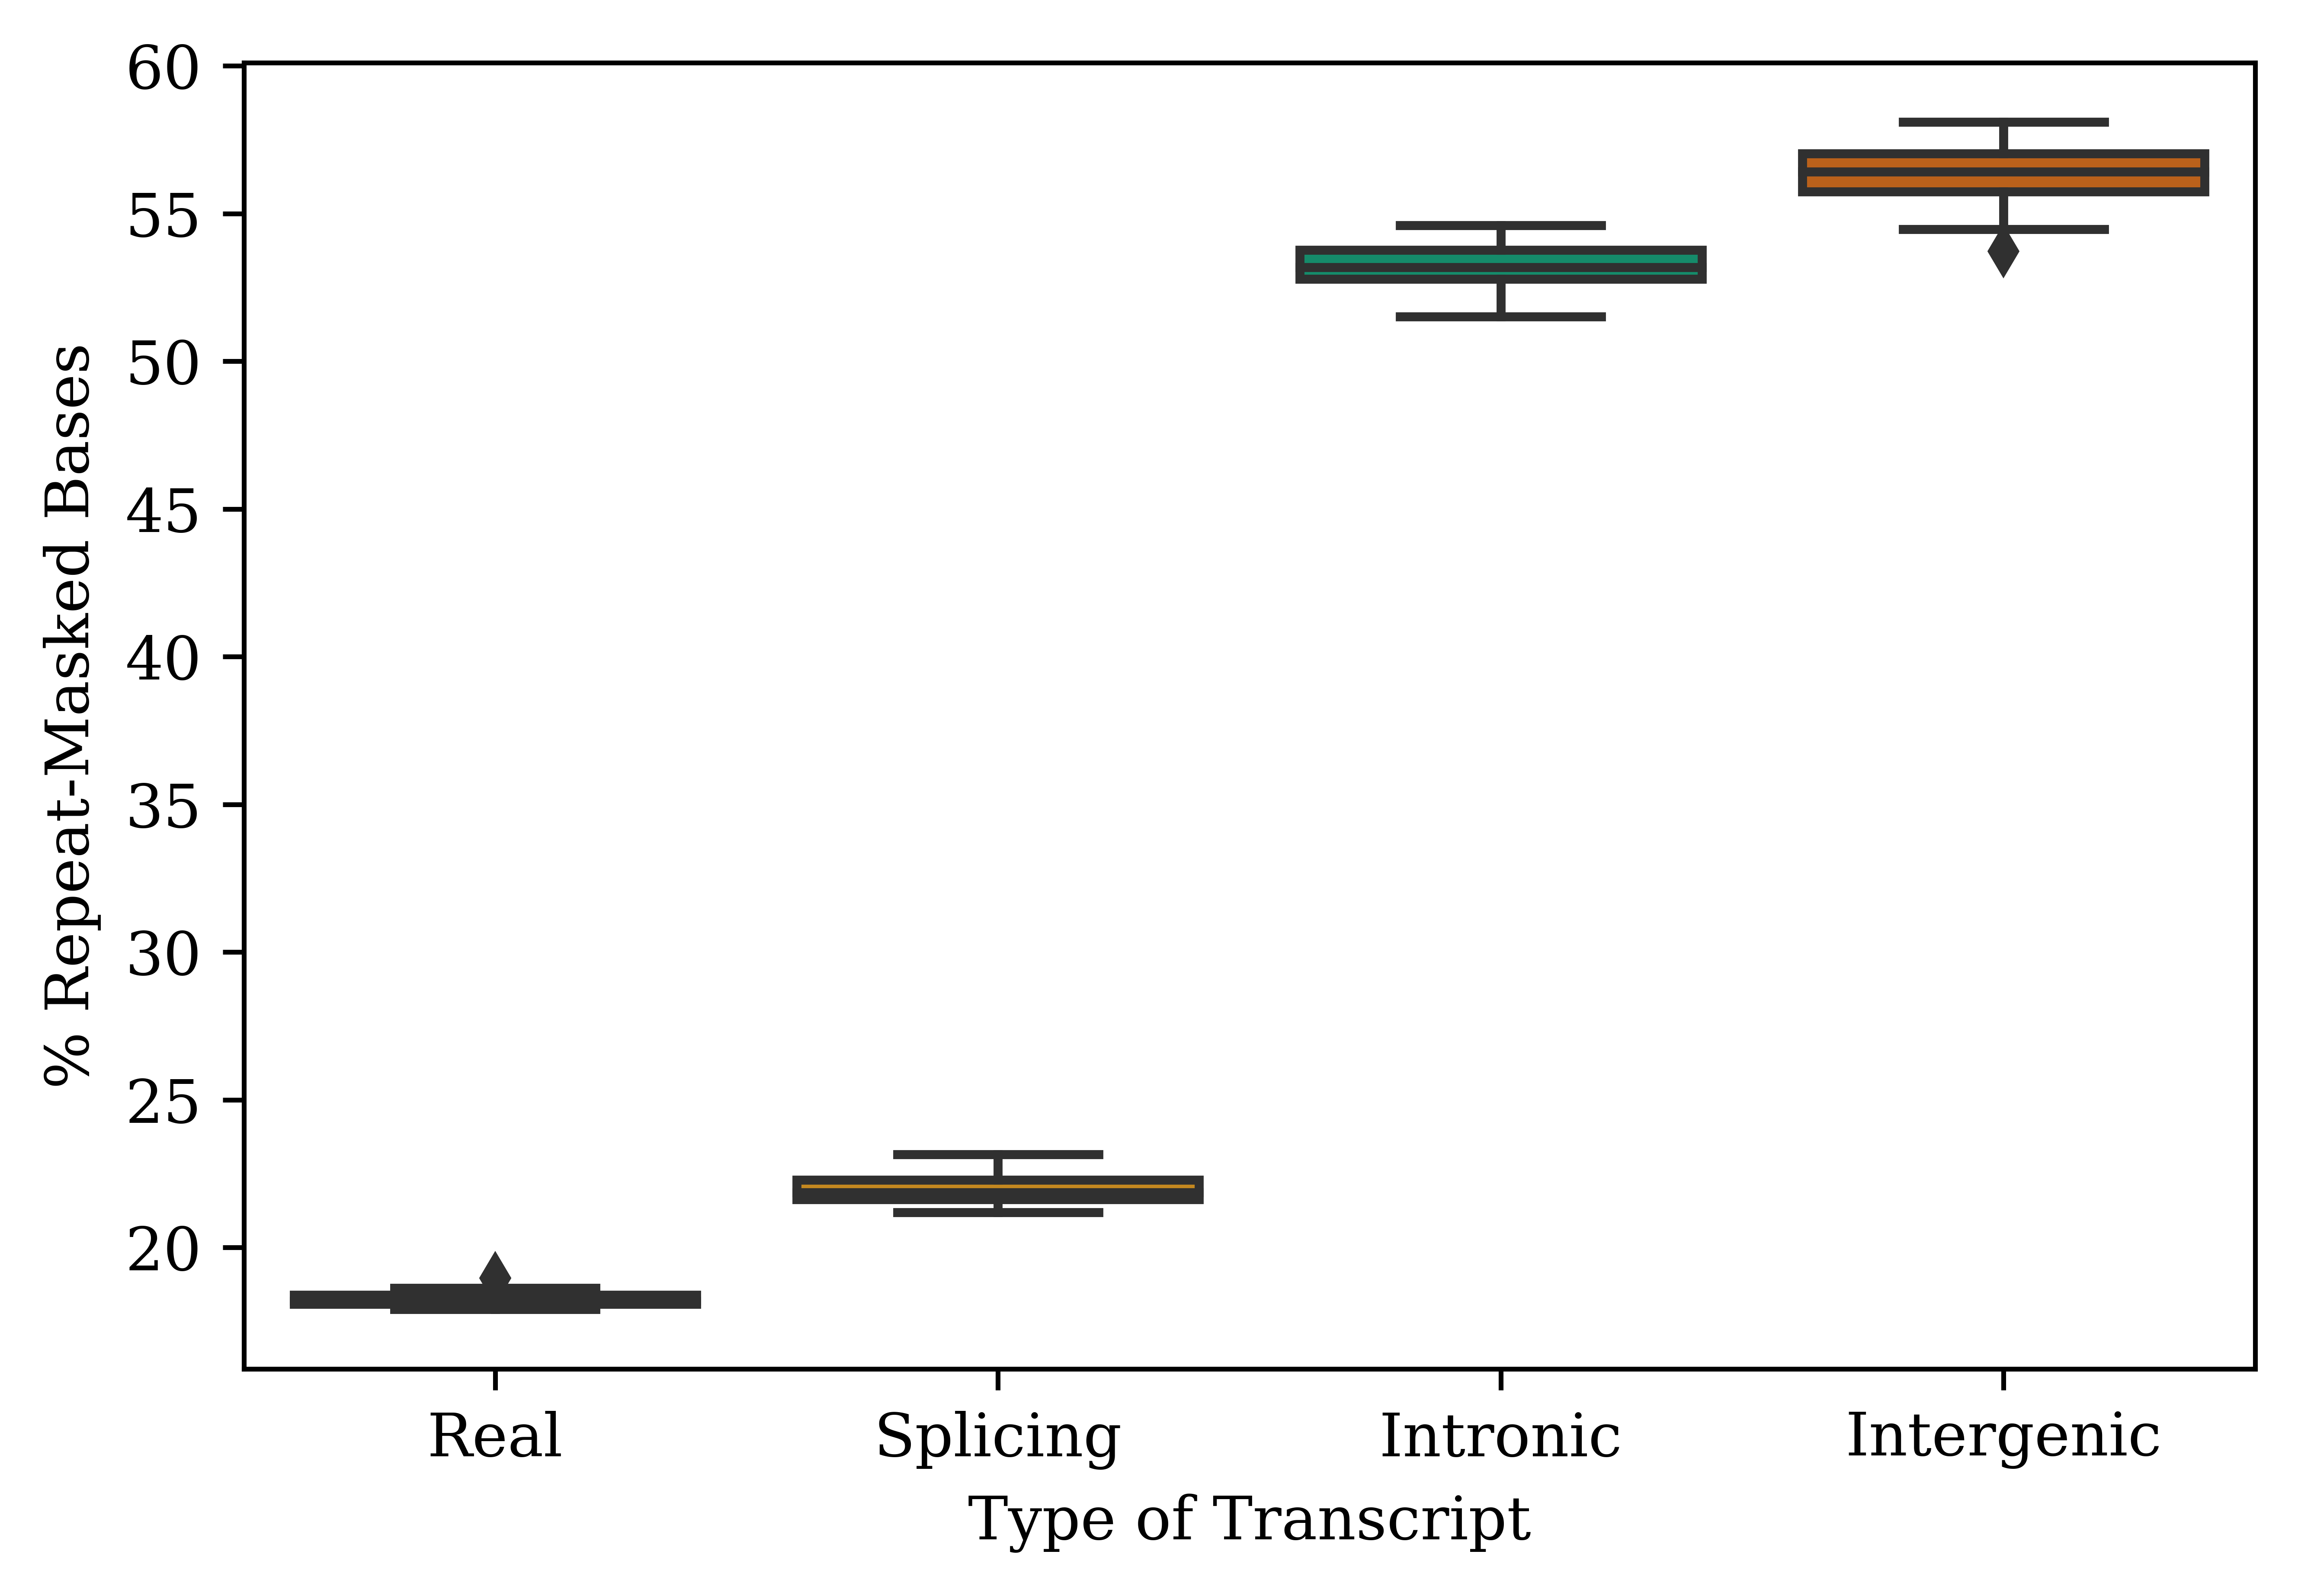

In [30]:
# plot
tmp2 = tmp2.replace({"real":"Real","splicing":"Splicing","intronic":"Intronic","intergenic":"Intergenic"})

plt.figure(dpi=1000)
params = {'font.size': 10}
plt.rcParams.update(params)
sns.set_palette("colorblind")
sns.boxplot(x="type",y="perc_repeat",data=tmp2,order=["Real","Splicing","Intronic","Intergenic"])
plt.xlabel("Type of Transcript")
plt.ylabel("% Repeat-Masked Bases")

[None, None, None, None, None, None, None, None]

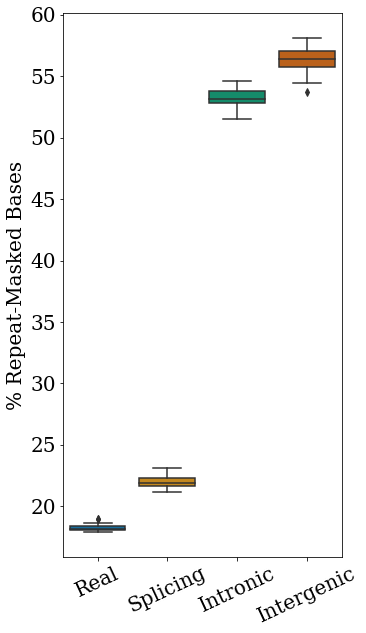

In [34]:
plt.figure(figsize=(5,10))
params = {'font.size': 20}
plt.rcParams.update(params)
sns.set_palette("colorblind")
sns.boxplot(x="type",y="perc_repeat",data=tmp2,order=["Real","Splicing","Intronic","Intergenic"])
plt.xlabel("")
plt.ylabel("% Repeat-Masked Bases")
plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=25)